In [1]:
#Importing Necessary Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')

### Load and Check Data

In [2]:
books = pd.read_csv(r'C:\Users\suraj\Assignments\10-Recommandation System/book.csv', encoding='Latin1')
books

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6
...,...,...,...,...
9995,9996,162121,American Fried: Adventures of a Happy Eater.,7
9996,9997,162121,Cannibal In Manhattan,9
9997,9998,162121,How to Flirt: A Practical Guide,7
9998,9999,162121,Twilight,8


### About Dataset<a class="anchor" id="1.1"></a>
Contains 2182 users providing ratings from 0 as minimum and 10 as maximum about 9659 books.

### Data Exploration<a class="anchor" id="2"></a>

In [4]:
print('Number of Unique Users are {}'.format(len(books['User.ID'].unique())))

Number of Unique Users are 2182


In [6]:
print('Number of Unique Books are {}'.format(len(books['Book.Title'].unique())))

Number of Unique Books are 9659


In [8]:
books['Book.Rating'].value_counts()

8     2283
7     2076
10    1732
9     1493
5     1007
6      920
4      237
3      146
2       63
1       43
Name: Book.Rating, dtype: int64

In [10]:
books['User.ID'].unique()

array([276726, 276729, 276736, ..., 162113, 162121, 162129], dtype=int64)

In [11]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   10000 non-null  int64 
 1   User.ID      10000 non-null  int64 
 2   Book.Title   10000 non-null  object
 3   Book.Rating  10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


In [19]:
books.describe()

,Unnamed: 0,User.ID,Book.Rating
count,10000.00000,10000.000000,10000.00000
mean,5000.50000,95321.249800,7.56630
std,2886.89568,117645.703609,1.82152
min,1.00000,8.000000,1.00000
25%,2500.75000,2103.000000,7.00000
50%,5000.50000,3757.000000,8.00000
75%,7500.25000,162052.000000,9.00000
max,10000.00000,278854.000000,10.00000


In [20]:
books.isnull().any()

Unnamed: 0     False
User.ID        False
Book.Title     False
Book.Rating    False
dtype: bool

In [21]:
books.isnull().sum()

Unnamed: 0     0
User.ID        0
Book.Title     0
Book.Rating    0
dtype: int64

In [22]:
books.duplicated().sum()

0

In [23]:
books[books.duplicated()].shape

(0, 4)

In [24]:
books[books.duplicated()]

,Unnamed: 0,User.ID,Book.Title,Book.Rating


Let's create a ratings dataframe with average rating and number of ratings:

In [29]:
books.groupby('Book.Title')['Book.Rating'].mean().sort_values(ascending=False).head()

Book.Title
Dr Mommy (From Here To Maternity) (Silhouette Desire, 1269)                                                           10.0
The Piano Man's Daughter                                                                                              10.0
Private Screening                                                                                                     10.0
The Pilates Body: The Ultimate At-Home Guide to Strengthening, Lengthening, and Toning Your Body--Without Machines    10.0
Desert Solitaire                                                                                                      10.0
Name: Book.Rating, dtype: float64

As we do not know the number of times the above 10 Rated books are rated we cannot take these ratings into consideration until a number of Users have rated the same books a considerate times

In [30]:
books.groupby('Book.Title')['Book.Rating'].count().sort_values(ascending=False).head(10)

Book.Title
Fahrenheit 451                                     5
Ender's Game (Ender Wiggins Saga (Paperback))      4
Stardust                                           4
Vanished                                           4
Charlie and the Chocolate Factory                  4
The Subtle Knife (His Dark Materials, Book 2)      4
The Amber Spyglass (His Dark Materials, Book 3)    4
The Golden Compass (His Dark Materials, Book 1)    3
Pet Sematary                                       3
My Side of the Mountain                            3
Name: Book.Rating, dtype: int64

In [32]:
ratings = pd.DataFrame(books.groupby('Book.Title')['Book.Rating'].mean())
ratings.head()

,Book.Rating
Book.Title,
"Jason, Madison &amp",8.0
Other Stories;Merril;1985;McClelland &amp,6.0
Repairing PC Drives &amp,4.0
'48,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0


In [33]:
ratings['num of ratings'] = pd.DataFrame(books.groupby('Book.Title')['Book.Rating'].count())
ratings.head()

,Book.Rating,num of ratings
Book.Title,,
"Jason, Madison &amp",8.0,1
Other Stories;Merril;1985;McClelland &amp,6.0,1
Repairing PC Drives &amp,4.0,1
'48,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0,1


### Data Visualization<a class="anchor" id="3"></a>

<AxesSubplot:>

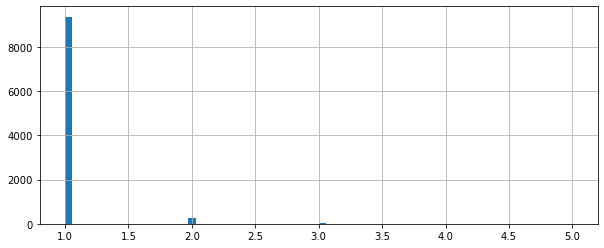

In [34]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

##### Observation: Maximum Number of Books are Rated only Once 

<AxesSubplot:>

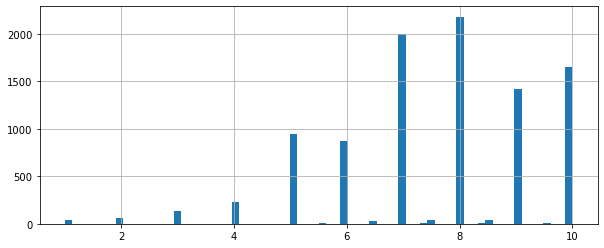

In [36]:
plt.figure(figsize=(10,4))
ratings['Book.Rating'].hist(bins=70)

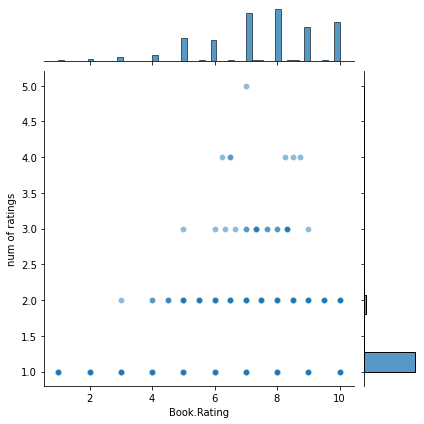

In [38]:
sns.jointplot(x='Book.Rating',y='num of ratings',data=ratings,alpha=0.5)

Text(0.5, 1.0, 'Ratings Frequency')

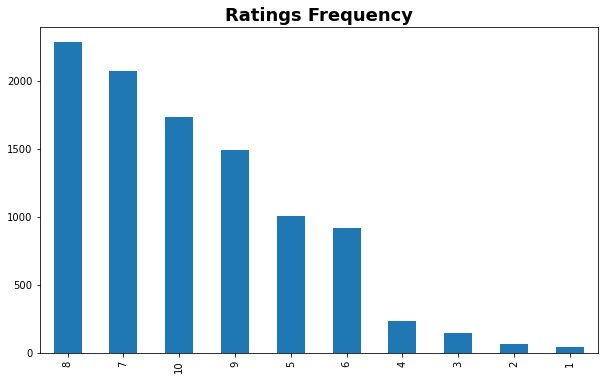

In [39]:
plt.figure(figsize=(10,6))
books['Book.Rating'].value_counts().plot(kind='bar')
plt.title('Ratings Frequency',  fontsize = 18, fontweight = 'bold')

### Observations:
+ #### Most Frequent Ratings by Users are: 8,7 and 10

In [40]:
top_books = books['Book.Title'].value_counts().head(10)
top_books.index

Index(['Fahrenheit 451', 'Charlie and the Chocolate Factory',
       'The Subtle Knife (His Dark Materials, Book 2)', 'Vanished',
       'Ender's Game (Ender Wiggins Saga (Paperback))', 'Stardust',
       'The Amber Spyglass (His Dark Materials, Book 3)', 'Life Is Elsewhere',
       'The Golden Compass (His Dark Materials, Book 1)',
       'The Hitchhiker's Guide to the Galaxy'],
      dtype='object')

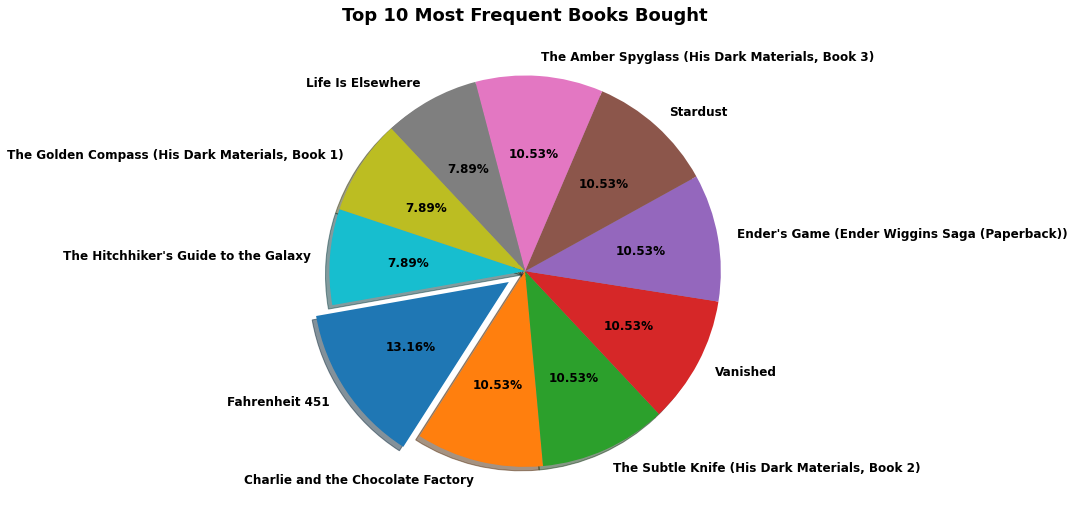

In [41]:
plt.figure(figsize = (16,9))
plt.pie(top_books,
       labels=top_books.index,
       explode = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
#plt.legend(loc= 'best')
plt.title("Top 10 Most Frequent Books Bought", fontsize = 18, fontweight = 'bold')
plt.show()

### Data Pre-Processing<a class="anchor" id="4"></a>

In [46]:
# Renaming the columns name
books.rename({'Unnamed: 0':'index','User.ID':'user_id','Book.Title':'title','Book.Rating':'rating'}, axis= 1, inplace =True)
books.set_index('index', inplace=True)
books

,user_id,title,rating
index,,,
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6
4,276736,Flu: The Story of the Great Influenza Pandemic...,8
5,276737,The Mummies of Urumchi,6
...,...,...,...
9996,162121,American Fried: Adventures of a Happy Eater.,7
9997,162121,Cannibal In Manhattan,9
9998,162121,How to Flirt: A Practical Guide,7


### Collaborative Book Recommendation System<a class="anchor" id="5"></a>

### Creating Pivot Table<a class="anchor" id="5.1"></a>

In [47]:
user_books_df = books.pivot_table(index='user_id',columns = 'title', values = 'rating').fillna(0)
user_books_df

title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [48]:
# Calculating Cosine Similarity between Users
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [49]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,Book.Rating,num of ratings
Book.Title,,
Fahrenheit 451,7.000000,5
Ender's Game (Ender Wiggins Saga (Paperback)),6.250000,4
Stardust,8.500000,4
Vanished,6.500000,4
Charlie and the Chocolate Factory,6.500000,4
"The Subtle Knife (His Dark Materials, Book 2)",8.750000,4
"The Amber Spyglass (His Dark Materials, Book 3)",8.250000,4
"The Golden Compass (His Dark Materials, Book 1)",8.333333,3
Pet Sematary,7.666667,3


In [50]:
stardust_user_ratings = user_books_df['Stardust']
fahrenheit_user_rating = user_books_df['Fahrenheit 451']
fahrenheit_user_rating.head()

user_id
8     0.0
9     0.0
10    0.0
12    0.0
14    0.0
Name: Fahrenheit 451, dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [51]:
similar_to_fahrenheit = user_books_df.corrwith(fahrenheit_user_rating)
similar_to_stardust = user_books_df.corrwith(stardust_user_ratings)

In [52]:
corr_fahrenheit = pd.DataFrame(similar_to_fahrenheit,columns=['Correlation'])
corr_fahrenheit.dropna(inplace=True)
corr_fahrenheit.head()

,Correlation
title,
"Jason, Madison &amp",-0.000958
Other Stories;Merril;1985;McClelland &amp,-0.000958
Repairing PC Drives &amp,-0.000958
'48,-0.000958
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie)

In [53]:
corr_fahrenheit.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Fahrenheit 451,1.000000
The Day I Swapped My Dad for 2 Goldfish,0.596326
Black Market,0.596326
"For The Love Of Beau (Delta Justice) (Delta Justice , No 9)",0.596326
A la vora del pou (El BalancÃ­),0.596326
Mr. Punch,0.596326
Contes de fÃ?Â©es Ã?Â l'usage des moyennes personnes,0.596326
Marriage By Contract (36 Hours) (Harlequin 36 Hours),0.596326
"The Doll's House (Sandman, Book 2)",0.596326


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [55]:
corr_fahrenheit = corr_fahrenheit.join(ratings['Book.Rating'])
corr_fahrenheit.head()

,Correlation,Book.Rating
title,,
"Jason, Madison &amp",-0.000958,8.0
Other Stories;Merril;1985;McClelland &amp,-0.000958,6.0
Repairing PC Drives &amp,-0.000958,4.0
'48,-0.000958,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958,8.0


Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

### Recommending Similar Books Using  Correlation<a class="anchor" id="5.2"></a>
#### Based on Ratings
Now let's create a matrix that has the user ids on one axis and the movie title on another axis. Each cell will then consist of the rating the users gave to that Book. Note there will be a lot of NaN values, because most people have not given rating to most of the books.

In [57]:
corr_fahrenheit[corr_fahrenheit['Book.Rating']>5].sort_values('Correlation',ascending=False).head()

,Correlation,Book.Rating
title,,
Fahrenheit 451,1.000000,7.0
The Day I Swapped My Dad for 2 Goldfish,0.596326,9.0
The Onion Girl,0.596326,7.0
Tap d'escopeta (MÃ­nima de butxaca),0.596326,7.0
Contes de fÃ?Â©es Ã?Â l'usage des moyennes personnes,0.596326,7.0


In [58]:
corr_stardust = pd.DataFrame(similar_to_stardust,columns=['Correlation'])
corr_stardust.dropna(inplace=True)
corr_stardust = corr_stardust.join(ratings['num of ratings'])
corr_stardust[corr_stardust['num of ratings']>4].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Fahrenheit 451,-0.001908,5


## Collaborative Recommender System Using Cosine Similarity<a class="anchor" id="5.3"></a>

In [59]:
user_books_df.head()

title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Calculating Cosine Similarity between Users
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [61]:
user_sim = 1 - pairwise_distances(user_books_df.values, metric = 'cosine')
user_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [62]:
# Store the results in a dataframe
user_sim_df = pd.DataFrame(user_sim)
user_sim_df

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
user_sim_df.iloc[:5,:5]

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [64]:
np.fill_diagonal(user_sim, 0)
user_sim_df.iloc[0:5,0:5]

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [65]:
# Set the index and column name to user Ids
user_sim_df.index = list(user_books_df.index)
user_sim_df.columns = list(user_books_df.index)
user_sim_df

,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
user_id_eight = user_sim_df.sort_values([9], ascending=False).head(100)
user_id_eight[9]

8         0.0
161755    0.0
161744    0.0
161749    0.0
161750    0.0
         ... 
161441    0.0
161436    0.0
161434    0.0
161431    0.0
161423    0.0
Name: 9, Length: 100, dtype: float64

In [67]:
books[(books['user_id']==8) | (books['user_id']==14)]

,user_id,title,rating
index,,,
2400,8,Ancient Celtic Romances,5
2401,8,The Western way: A practical guide to the West...,5
2402,8,Wings,5
2403,8,Truckers,5
2404,8,Keepers of the Earth Teachers Guide,6
2405,8,The Celts Activity Book,6
2406,8,The Art Of Celtia,7
2410,14,COPS,5
2411,14,A Cold Heart: An Alex Delaware Novel,5


In [68]:
# Most Similar Users
user_sim_df.idxmax(axis=1)

8              8
9              8
10             8
12             8
14             8
           ...  
278846         8
278849         8
278851    278202
278852         8
278854         8
Length: 2182, dtype: int64

In [69]:
books[(books['user_id']==8) | (books['user_id']==14)]

,user_id,title,rating
index,,,
2400,8,Ancient Celtic Romances,5
2401,8,The Western way: A practical guide to the West...,5
2402,8,Wings,5
2403,8,Truckers,5
2404,8,Keepers of the Earth Teachers Guide,6
2405,8,The Celts Activity Book,6
2406,8,The Art Of Celtia,7
2410,14,COPS,5
2411,14,A Cold Heart: An Alex Delaware Novel,5


### Recommnedation Based on Cosine Similarity<a class="anchor" id="5.4"></a>

In [70]:
def give_reco(customer_id):
    tem = list(user_sim_df.sort_values([customer_id],ascending=False).head(100).index)
    #print('similar customer ids:',tem)
    movie_list=[]
    for i in tem:
        movie_list=movie_list+list(books[books['user_id']==i]['title'])
    #print('Common movies within customer',movie_list)
    return set(movie_list)-set(books[books['user_id']==customer_id]['title'])

In [71]:
give_reco(14)

{"'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '20,001 Names for Baby',
 '24 Hours',
 '500 palabras nuevas para ti / 500 Words To Grow On',
 'A Cat in the Manger: An Alice Nestleton Mystery (Alice Nestleton Mysteries (Paperback))',
 'A Certain Justice: A Novel',
 "A Child's Night Dream",
 'A Darkness More Than Night',
 'A Dog Year: Twelve Months, Four Dogs, and Me',
 "A False Sense of Well Being (Ballantine Reader's Circle)",
 'A Flash in the Pan: 100 Fast and Furious Recipes for Wok and Stir-Fry',
 'A Free Man of Color (Benjamin January (Paperback))',
 'A GATHERING OF SAINTS',
 'A Lady Never Trifles with Thieves',
 'A Letter of Mary (Mary Russell Novels (Paperback))',
 'A Letter to Harvey Milk: Short Stories',
 'A Light in the Attic',
 'A Pocket Guide to Oahu',
 "A Single Tear: A Family's Persecution, Love, and Endurance in Communist China",
 'A Wreath for Rivera',
 'A lexicon of Jewish cooking: A collection of folklore, foodlore, history, customs, and reci

In [72]:
give_reco(8)

{"'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '20,001 Names for Baby',
 '24 Hours',
 '500 palabras nuevas para ti / 500 Words To Grow On',
 'A Cat in the Manger: An Alice Nestleton Mystery (Alice Nestleton Mysteries (Paperback))',
 'A Certain Justice: A Novel',
 "A Child's Night Dream",
 'A Darkness More Than Night',
 'A Dog Year: Twelve Months, Four Dogs, and Me',
 "A False Sense of Well Being (Ballantine Reader's Circle)",
 'A Flash in the Pan: 100 Fast and Furious Recipes for Wok and Stir-Fry',
 'A Free Man of Color (Benjamin January (Paperback))',
 'A GATHERING OF SAINTS',
 'A Lady Never Trifles with Thieves',
 'A Letter of Mary (Mary Russell Novels (Paperback))',
 'A Letter to Harvey Milk: Short Stories',
 'A Light in the Attic',
 'A Pocket Guide to Oahu',
 "A Single Tear: A Family's Persecution, Love, and Endurance in Communist China",
 'A Wreath for Rivera',
 'A lexicon of Jewish cooking: A collection of folklore, foodlore, history, customs, and reci